# Коэффициент восстановления золота

Необходимо построить прототип модели машинного обучения для предсказания коэффициента восстановления золота из золотосодержащей руды на основании данных с параметрами добычи и очистки. Данная модель поможет оптимизировать производство предприятия.

### Библиотеки и модули

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

### Содержание

1. Подготовка данных  
    - Изучение общей информации о данных 
    - Предобработка данных
        - Работа с дубликатами
        - Работа с пропусками  
    - Проверка рассчета rougher.output.recovery  
    - Анализ признаков, недоступных в тестовой выборке
2. Анализ данных  
    - Изменение концентрации металлов на разных этапах очистки  
    - Распределения размеров гранул сырья на обучающей и тестовой выборках  
    - Суммарная концентрация всех веществ на разных стадиях  
3. Построение модели  
    - Функция для вычисления MAPE  
    - Построение моделей  
    - Отбор и тестирование лучшей модели  
    - Проверка на адекватность
4. Вывод

## Подготовка данных

### Изучение общей информации о данных

In [2]:
path_train = '/datasets/gold_recovery_train.csv'
path_test = '/datasets/gold_recovery_test.csv'
path_full = '/datasets/gold_recovery_full.csv'

In [3]:
data_train = pd.read_csv(path_train)
data_test = pd.read_csv(path_test)
data_full = pd.read_csv(path_full)

#### data_train

In [4]:
data_train.head(1)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.19202,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198


In [5]:
data_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [7]:
data_train['final.output.concentrate_au'].describe()

count    16789.000000
mean        39.467217
std         13.917227
min          0.000000
25%         42.055722
50%         44.498874
75%         45.976222
max         53.611374
Name: final.output.concentrate_au, dtype: float64

Во всех столбцах кроме data и primary_cleaner.input.feed_size содержатся пропуски.

#### data_test

In [8]:
data_test.head(1)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.31785,4.872511,-500.037437,26.705889,-499.709414


In [9]:
data_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [10]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

### Предобработка данных

На этапе предобработки данных в целом перед нами стоит вопрос заполнения пропусков и поиска дубликатов в данных.

#### Работа с дубликатами

In [11]:
print(f'Дубликатов в таблице data_train: {data_train.duplicated().sum()}')
print(f'Дубликатов в таблице data_test: {data_test.duplicated().sum()}')
print(f'Дубликатов в таблице data_full: {data_full.duplicated().sum()}')

Дубликатов в таблице data_train: 0
Дубликатов в таблице data_test: 0
Дубликатов в таблице data_full: 0


#### Работа с пропусками

##### data_train

In [12]:
data_train.isnull().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [13]:
data_train.isnull().sum() / data_train.shape[0] * 100

date                                          0.000000
final.output.concentrate_ag                   0.427046
final.output.concentrate_pb                   0.427046
final.output.concentrate_sol                  2.194543
final.output.concentrate_au                   0.421115
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.504152
secondary_cleaner.state.floatbank5_b_air      0.504152
secondary_cleaner.state.floatbank5_b_level    0.498221
secondary_cleaner.state.floatbank6_a_air      0.610913
secondary_cleaner.state.floatbank6_a_level    0.504152
Length: 87, dtype: float64

In [14]:
print(f"В целевой перменной rougher.output.recovery содержится {round(data_train['rougher.output.recovery'].isnull().sum() / data_train.shape[0] * 100, 2)}% пропусков.")

В целевой перменной rougher.output.recovery содержится 15.26% пропусков.


В целевой перменной содержится довольно большой процент пропусков. Связан ли он с тем, что есть пропуски в признаках для ее рассчета? Или, наоборот, данные для подсчета есть, но сама целевая переменная посчитана не была? Признаки необходимые для расчета показателся эффективности после флотации: rougher.output.tail_au, rougher.input.feed_au, rougher.output.tail_au и rougher.input.feed_size.

Рассмотрим случай, в котором у объектов значения в данных признаках не пропущены, но пропущено значение целевого признака. В ином случае, остальные объекты выкинем из выборки.

In [15]:
def objects_rougher_output_recovery(step, data):
    if step == 'rougher':
        return data_train.loc[(data[f'{step}.input.feed_size'].isnull() == False) & 
                          (data[f'{step}.output.tail_au'].isnull() == False) & 
                          (data[f'{step}.input.feed_au'].isnull() == False) & 
                          (data[f'{step}.output.tail_au'].isnull() == False) & 
                          (data[f'{step}.output.recovery'].isnull() == True)]
    elif step == 'final':
        return data_train.loc[(data[f'{step}.input.feed_size'].isnull() == False) & 
                          (data[f'{step}.output.tail_au'].isnull() == False) & 
                          (data[f'{step}.input.feed_au'].isnull() == False) & 
                          (data[f'{step}.output.tail_au'].isnull() == False) & 
                          (data[f'{step}.output.recovery'].isnull() == True)]

In [16]:
objects_rougher_output = objects_rougher_output_recovery('rougher', data_train)

In [17]:
print(f'Таких объектов: {round(objects_rougher_output.shape[0] / data_train.shape[0] * 100, 2)}%')

Таких объектов: 1.91%


Таких объектов около 2%. Восстановим значения целевой переменной по данным признакам, сохраним хоть и небольшую, но возможно полезную долю информации при обучении.

In [18]:
idxes_for_recovery_rougher = objects_rougher_output.index.tolist()

In [19]:
def calc_rougher_output_recovery(row):
    tail_au = row['rougher.output.tail_au']
    feed_au = row['rougher.input.feed_au']
    output_au = row['rougher.output.concentrate_au']
    try:
        t = tail_au
        c = output_au
        f = feed_au
        return ((c * (f - t)) / (f * (c - t))) * 100
    except ZeroDivisionError:
        return 0

In [21]:
data_train.loc[idxes_for_recovery_rougher, 'rougher.output.recovery_check'] = data_train.apply(calc_rougher_output_recovery, axis=1)

In [22]:
data_train.loc[idxes_for_recovery_rougher, 'rougher.output.recovery_check']

53          188.742102
372       -3913.312866
377        -116.312118
560          -1.086185
700     -112789.873301
             ...      
16697       112.957805
16698       100.442153
16699        -0.482567
16700        -0.584325
16701        -1.498298
Name: rougher.output.recovery_check, Length: 322, dtype: float64

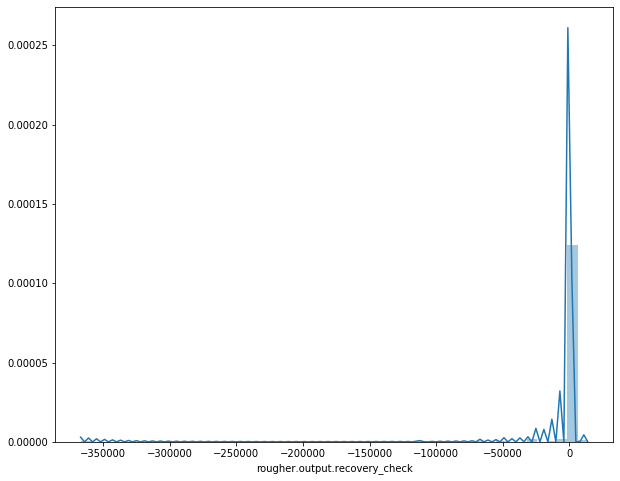

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(data_train.loc[idxes_for_recovery_rougher, 'rougher.output.recovery_check'], bins=50)
plt.show()

Видим, что есть значения меньше 0. А это не порядок совсем...

In [24]:
data_train.drop(['rougher.output.recovery_check'], axis=1, inplace=True)

Удалим объекты, у которых есть пропуски в целевой переменной rougher.output.recovery.

In [25]:
idxes_for_drop = data_train.loc[data_train['rougher.output.recovery'].isnull() == True].index.tolist()
data_train.drop(idxes_for_drop, axis=0, inplace=True)

In [26]:
print(f"В целевой перменной rougher.output.recovery содержится {round(data_train['rougher.output.recovery'].isnull().sum() / data_train.shape[0] * 100, 2)}% пропусков.")

В целевой перменной rougher.output.recovery содержится 0.0% пропусков.


*Важно заметить, что в данной задаче у нас два целевых прихнака.*

Подобно тому, как мы провели работу с целевым признаком rougher.output.recovery, проведем аналогичную работу и с final.output.recovery.

In [27]:
print(f"В целевой перменной final.output.recovery содержится {round(data_train['final.output.recovery'].isnull().sum() / data_train.shape[0] * 100, 2)}% пропусков.")

В целевой перменной final.output.recovery содержится 0.97% пропусков.


Пропусков достаточно мало, поэтому удаление данных объектов не отразится сильно на результатах модели.

In [28]:
data_train.drop(data_train.loc[data_train['final.output.recovery'].isnull() == True].index.tolist(), axis=0, inplace=True)

In [29]:
print(f"В целевой перменной final.output.recovery содержится {round(data_train['final.output.recovery'].isnull().sum() / data_train.shape[0] * 100, 2)}% пропусков.")

В целевой перменной final.output.recovery содержится 0.0% пропусков.


Поскольку данные имеют временной характер заполнения в процессе производства. Можно предположить, что ближайшие объекты по времени похожи. Заполним пропуски ближайшим значением ffill.

In [30]:
data_train.fillna(method='ffill', inplace=True)

In [31]:
data_train.isnull().sum() / data_train.shape[0] * 100

date                                          0.0
final.output.concentrate_ag                   0.0
final.output.concentrate_pb                   0.0
final.output.concentrate_sol                  0.0
final.output.concentrate_au                   0.0
                                             ... 
secondary_cleaner.state.floatbank5_a_level    0.0
secondary_cleaner.state.floatbank5_b_air      0.0
secondary_cleaner.state.floatbank5_b_level    0.0
secondary_cleaner.state.floatbank6_a_air      0.0
secondary_cleaner.state.floatbank6_a_level    0.0
Length: 87, dtype: float64

##### data_test

Заметим, что в тестовой выборке отсутствуют значения целевых переменных.

In [32]:
data_test.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [34]:
data_test = data_test.merge(data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], how='inner', on='date')

In [35]:
data_test.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


Найдем количество пропущенных объектов в целевых переменных.

In [36]:
print(f"В целевой перменной final.output.recovery содержится {round(data_test['final.output.recovery'].isnull().sum() / data_test.shape[0] * 100, 2)}% пропусков.")
print(f"В целевой перменной rougher.output.recovery содержится {round(data_test['rougher.output.recovery'].isnull().sum() / data_test.shape[0] * 100, 2)}% пропусков.")

В целевой перменной final.output.recovery содержится 7.55% пропусков.
В целевой перменной rougher.output.recovery содержится 9.32% пропусков.


Поскольку не хватает признаков для восставновление каких-либо значений целевых переменных, то удалим эти объекты.

In [37]:
data_test.dropna(subset=['final.output.recovery', 'rougher.output.recovery'], inplace=True)

In [38]:
print(f"В целевой перменной final.output.recovery содержится {round(data_test['final.output.recovery'].isnull().sum() / data_test.shape[0] * 100, 2)}% пропусков.")
print(f"В целевой перменной rougher.output.recovery содержится {round(data_test['rougher.output.recovery'].isnull().sum() / data_test.shape[0] * 100, 2)}% пропусков.")

В целевой перменной final.output.recovery содержится 0.0% пропусков.
В целевой перменной rougher.output.recovery содержится 0.0% пропусков.


In [39]:
data_test.isnull().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

Заполним пропуски также ближайшими значениями.

In [40]:
data_test.fillna(method='ffill', inplace=True)

### Проверка рассчета rougher.output.recovery

In [41]:
data_train['rougher.output.recovery'].describe()

count    14149.000000
mean        82.704502
std         14.479156
min          0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [42]:
data_train['rougher.output.recovery_calc'] = data_train.apply(calc_rougher_output_recovery, axis=1)

In [43]:
data_train[['rougher.output.recovery', 'rougher.output.recovery_calc']].head(5)

,rougher.output.recovery,rougher.output.recovery_calc
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [44]:
print(f"MAE: {mean_absolute_error(data_train['rougher.output.recovery_calc'], data_train['rougher.output.recovery'])}")

MAE: 9.46896498277233e-15


In [45]:
data_train.drop(['rougher.output.recovery_calc'], axis=1, inplace=True)

### Анализ признаков, недоступных в тестовой выборке

Параметры относятся к количественному типу (float64).

In [46]:
train_columns = data_train.columns.tolist()
test_columns= data_test.columns.tolist()

In [47]:
print('В тренировочной выборке отсутствуют признаки:')
for column in train_columns:
    if column not in test_columns:
        print(f' - {column};')

В тренировочной выборке отсутствуют признаки:
 - final.output.concentrate_ag;
 - final.output.concentrate_pb;
 - final.output.concentrate_sol;
 - final.output.concentrate_au;
 - final.output.tail_ag;
 - final.output.tail_pb;
 - final.output.tail_sol;
 - final.output.tail_au;
 - primary_cleaner.output.concentrate_ag;
 - primary_cleaner.output.concentrate_pb;
 - primary_cleaner.output.concentrate_sol;
 - primary_cleaner.output.concentrate_au;
 - primary_cleaner.output.tail_ag;
 - primary_cleaner.output.tail_pb;
 - primary_cleaner.output.tail_sol;
 - primary_cleaner.output.tail_au;
 - rougher.calculation.sulfate_to_au_concentrate;
 - rougher.calculation.floatbank10_sulfate_to_au_feed;
 - rougher.calculation.floatbank11_sulfate_to_au_feed;
 - rougher.calculation.au_pb_ratio;
 - rougher.output.concentrate_ag;
 - rougher.output.concentrate_pb;
 - rougher.output.concentrate_sol;
 - rougher.output.concentrate_au;
 - rougher.output.tail_ag;
 - rougher.output.tail_pb;
 - rougher.output.tail_sol;

In [48]:
for i in list(set(data_train.columns) - set(data_test.columns)):
    print(i)

rougher.output.concentrate_au
final.output.concentrate_pb
rougher.calculation.floatbank11_sulfate_to_au_feed
primary_cleaner.output.concentrate_sol
rougher.output.tail_au
rougher.output.tail_ag
final.output.tail_ag
primary_cleaner.output.concentrate_ag
rougher.output.tail_pb
primary_cleaner.output.tail_au
final.output.concentrate_ag
final.output.tail_sol
rougher.output.concentrate_pb
rougher.output.concentrate_sol
secondary_cleaner.output.tail_au
secondary_cleaner.output.tail_ag
final.output.tail_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.concentrate_pb
rougher.calculation.floatbank10_sulfate_to_au_feed
final.output.concentrate_au
primary_cleaner.output.tail_sol
rougher.output.concentrate_ag
secondary_cleaner.output.tail_pb
primary_cleaner.output.concentrate_au
rougher.calculation.sulfate_to_au_concentrate
final.output.tail_pb
rougher.calculation.au_pb_ratio
secondary_cleaner.output.tail_sol
rougher.output.tail_sol
final.output.concentrate_s

## Анализ данных

### Изменение концентрации металлов (Ag, Pb, Au) на разных этапах очистки

Для анализа данных используем выборку data_full.

In [49]:
data_full.isnull().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

Поскольку данная выборка не будет использоваться в моделях заполним пропуски просто ближайшими значениями.

In [50]:
data_full.fillna(method='ffill', inplace=True)

In [51]:
step = ['rougher_input', 'rougher_output', 'primary', 'second']
metalls = ['ag', 'pb', 'au']
delta_conc = pd.DataFrame(index=step, columns=metalls)

In [52]:
columns_for_calc = ['rougher.input.feed_au', 
                    'rougher.input.feed_pb',
                    'rougher.input.feed_ag',
                    'rougher.output.concentrate_ag', 
                    'rougher.output.concentrate_pb', 
                    'rougher.output.concentrate_au', 
                    'primary_cleaner.output.concentrate_ag', 
                    'primary_cleaner.output.concentrate_pb', 
                    'primary_cleaner.output.concentrate_au', 
                    'final.output.concentrate_ag', 
                    'final.output.concentrate_pb', 
                    'final.output.concentrate_au']

Возьмем медианное значение, чтобы исключить учет выбросов при анализе динамики концентрации металлов.

In [53]:
for column in columns_for_calc:
    if 'rougher.output' in column:
        if '_ag' in column:
            delta_conc.loc['rougher_output', 'ag'] = data_full[column].median()
        elif '_pb' in column:
            delta_conc.loc['rougher_output', 'pb'] = data_full[column].median()
        else:
            delta_conc.loc['rougher_output', 'au'] = data_full[column].median()
    elif 'rougher.input' in column:
        if '_ag' in column:
            delta_conc.loc['rougher_input', 'ag'] = data_full[column].median() / data_full['rougher.input.feed_size'].median() * 100
        elif '_pb' in column:
            delta_conc.loc['rougher_input', 'pb'] = data_full[column].median() / data_full['rougher.input.feed_size'].median() * 100
        else:
            delta_conc.loc['rougher_input', 'au'] = data_full[column].median() / data_full['rougher.input.feed_size'].median() * 100
    elif 'primary_cleaner' in column:
        if '_ag' in column:
            delta_conc.loc['primary', 'ag'] = data_full[column].median()
        elif '_pb' in column:
            delta_conc.loc['primary', 'pb'] = data_full[column].median()
        else:
            delta_conc.loc['primary', 'au'] = data_full[column].median()
    else:
        if '_ag' in column:
            delta_conc.loc['second', 'ag'] = data_full[column].median()
        elif '_pb' in column:
            delta_conc.loc['second', 'pb'] = data_full[column].median()
        else:
            delta_conc.loc['second', 'au'] = data_full[column].median()

In [54]:
delta_conc.reset_index(inplace=True)
header = ['step', 'ag', 'pb', 'au']
delta_conc.columns = header
delta_conc

,step,ag,pb,au
0,rougher_input,15.5479,6.40951,14.767
1,rougher_output,11.7741,7.57089,19.9955
2,primary,8.25606,9.88288,32.3455
3,second,4.94996,9.91036,44.639


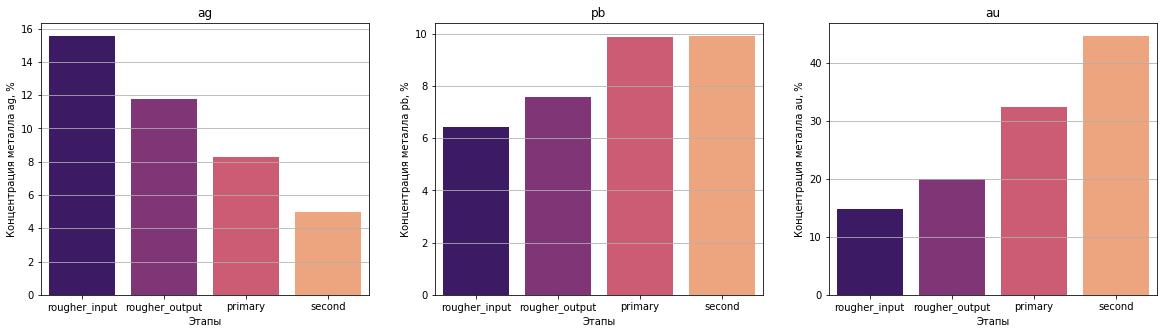

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i in range(len(metalls)):
    ax[i].set_title(metalls[i])
    ax[i].set_xlabel('Этапы')
    sns.barplot(data=delta_conc, x=step, y=metalls[i], ax=ax[i], palette='magma')
    ax[i].set_ylabel(f'Концентрация металла {metalls[i]}, %')
    ax[i].grid(axis='y')
plt.show()

#### Вывод

Видим, что с каждым этапом концентрация серебра (Ag) постепенно снижается. Так, до этапа флотации его концентрация составляет около 16%, на выходе этапа флотации уже 12%, после первого этапа очистки - около 8%, а на втором этапе очистки уже примерно 5%.  

Смотря на динамику концентрации свинца (Pb), видим что она возрастает. На начальном этапе концентрация составляет чуть более 6%, по окончании этапа флотации его концентрация увеличилась примерно на 1%, после первого этапа очистки примерно на 2% и остается в целом на том же уровне после второй очистки - 10%.  

Четко растет процент концентрации золота с каждым этапом: до флотации - 15%, после этапа флотации она составляет 20%. После первого этапа очистки увеличивается примерно на 12%. В конце второго этапа очистки имеем примерно 40% концентрации золота.

In [56]:
steps_au = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']

In [57]:
step = ['rougher_input', 'rougher_output', 'primary', 'second']
delta_conc_au = pd.DataFrame(columns=step)
delta_conc_au

,rougher_input,rougher_output,primary,second


In [58]:
for step_au in steps_au:
    if 'rougher.input' in step_au:
        delta_conc_au['rougher_input'] = data_full[step_au]
    elif 'rougher.output' in step_au:
        delta_conc_au['rougher_output'] = data_full[step_au]
    elif 'primary' in step_au:
        delta_conc_au['primary'] = data_full[step_au]
    else:
        delta_conc_au['second'] = data_full[step_au]

In [59]:
delta_conc_au

,rougher_input,rougher_output,primary,second
0,6.486150,19.793808,34.174427,42.192020
1,6.478583,20.050975,34.118526,42.701629
2,6.362222,19.737170,33.969464,42.657501
3,6.118189,19.320810,28.260743,42.689819
4,5.663707,19.216101,33.044932,42.774141
...,...,...,...,...
22711,5.335862,18.603550,32.940215,46.713954
22712,4.838619,18.441436,32.925325,46.866780
22713,4.525061,15.111231,31.856742,46.795691
22714,4.362781,17.834772,30.770892,46.408188


In [60]:
steps_pb = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
steps_ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']

delta_conc_pb = pd.DataFrame(columns=step)
delta_conc_ag = pd.DataFrame(columns=step)

for step_pb in steps_pb:
    if 'rougher.input' in step_pb:
        delta_conc_pb['rougher_input'] = data_full[step_pb]
    elif 'rougher.output' in step_pb:
        delta_conc_pb['rougher_output'] = data_full[step_pb]
    elif 'primary' in step_pb:
        delta_conc_pb['primary'] = data_full[step_pb]
    else:
        delta_conc_pb['second'] = data_full[step_pb]
        
for step_ag in steps_ag:
    if 'rougher.input' in step_ag:
        delta_conc_ag['rougher_input'] = data_full[step_ag]
    elif 'rougher.output' in step_ag:
        delta_conc_ag['rougher_output'] = data_full[step_ag]
    elif 'primary' in step_ag:
        delta_conc_ag['primary'] = data_full[step_ag]
    else:
        delta_conc_ag['second'] = data_full[step_ag]

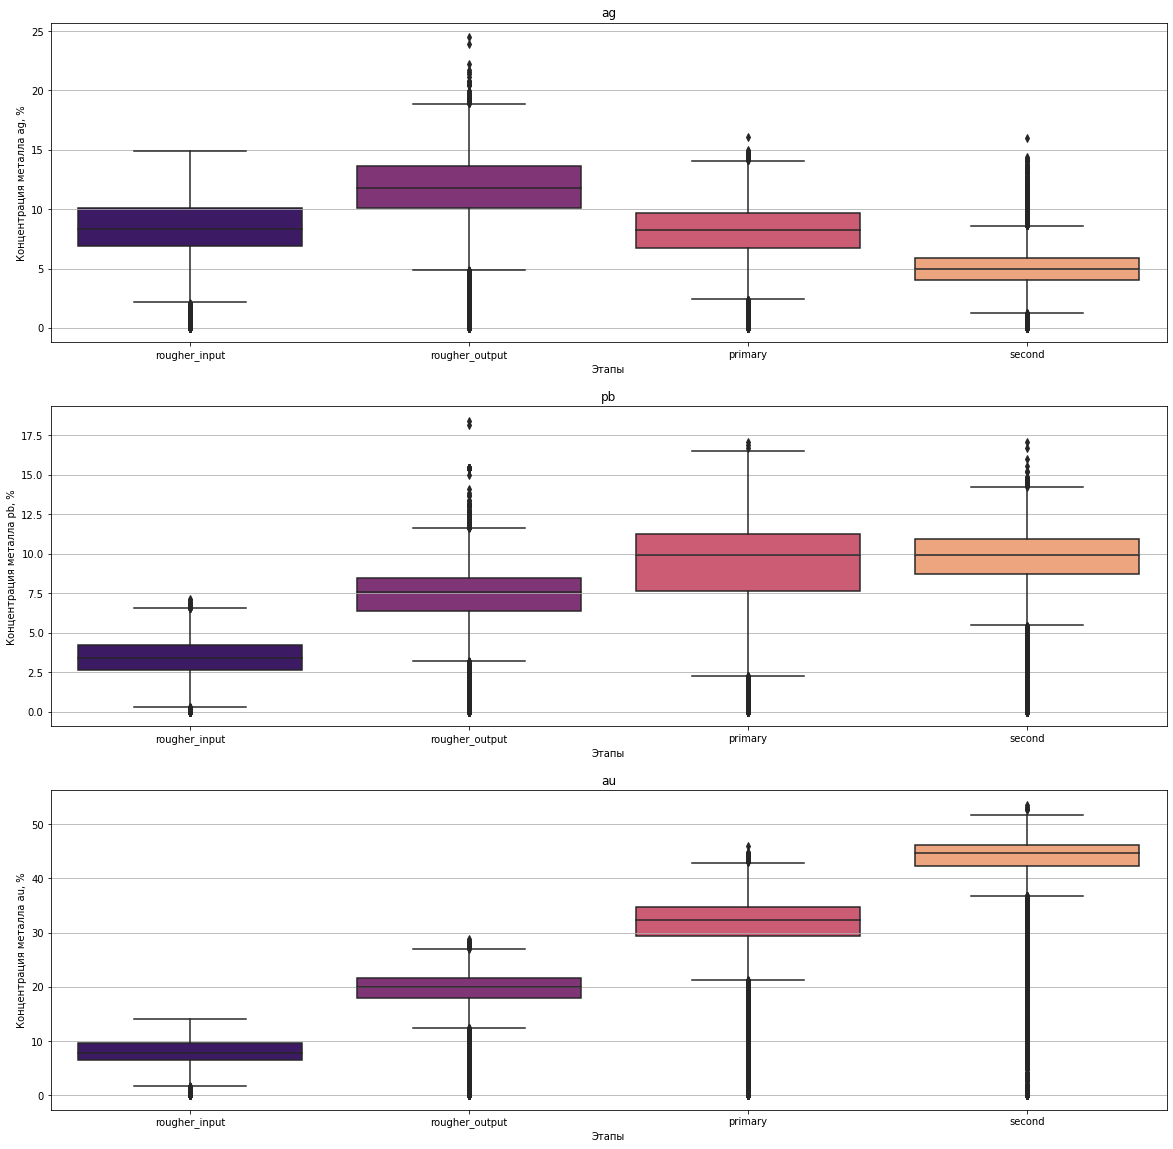

In [61]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
for i in range(len(metalls)):
    ax[i].set_title(metalls[i])
    ax[i].set_xlabel('Этапы')
    if metalls[i] == 'au':
        sns.boxplot(data=delta_conc_au, ax=ax[i], palette='magma')
        ax[i].set_ylabel(f'Концентрация металла {metalls[i]}, %')
        ax[i].grid(axis='y')
    elif metalls[i] == 'ag':
        sns.boxplot(data=delta_conc_ag, ax=ax[i], palette='magma')
        ax[i].set_ylabel(f'Концентрация металла {metalls[i]}, %')
        ax[i].grid(axis='y')
    else:
        sns.boxplot(data=delta_conc_pb, ax=ax[i], palette='magma')
        ax[i].set_ylabel(f'Концентрация металла {metalls[i]}, %')
        ax[i].grid(axis='y')
plt.show()

### Распределения размеров гранул сырья на обучающей и тестовой выборках

Рассмотрим распределения гранул сырья на обучающей и тестовой выборках. При получении отличных друг от друга распределений оценка модели будет смещена.

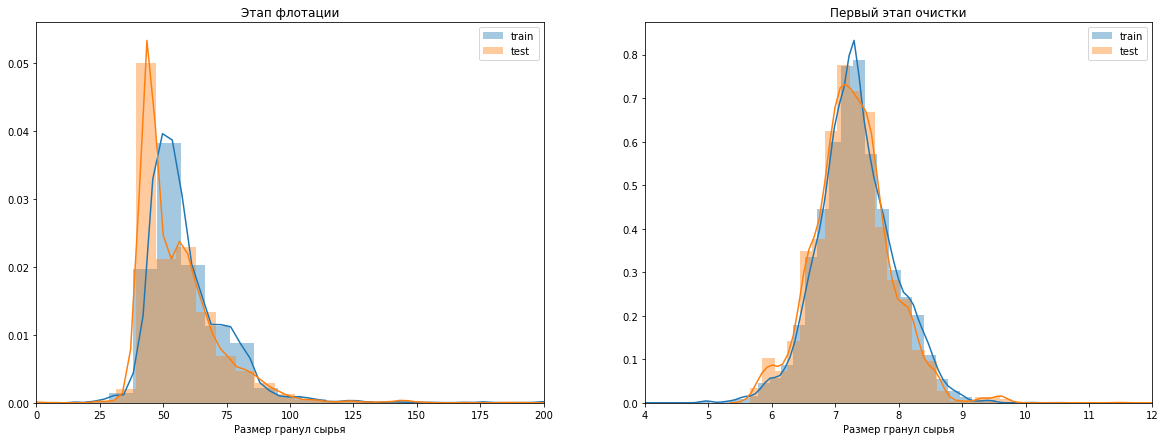

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
sns.distplot(data_train['rougher.input.feed_size'], ax=ax[0], bins=50, label='train')
sns.distplot(data_test['rougher.input.feed_size'], ax=ax[0], bins=50, label='test')
sns.distplot(data_train['primary_cleaner.input.feed_size'], ax=ax[1], bins=50, label='train')
sns.distplot(data_test['primary_cleaner.input.feed_size'], ax=ax[1], bins=50, label='test')
ax[0].set_title('Этап флотации')
ax[1].set_title('Первый этап очистки')
ax[0].set_xlabel('Размер гранул сырья')
ax[1].set_xlabel('Размер гранул сырья')
ax[0].set_xlim(0, 200)
ax[1].set_xlim(4, 12)
ax[0].legend()
ax[1].legend()
sns.set(style='darkgrid')
plt.show()

Видим, что распределения размера гранул сырья на первом этапе очистки почти не отличаются. Напротив, на этапе флотации различие распределений уже значительнее в примерном диапозоне 35-60.

### Суммарная концентрация всех веществ на разных стадиях

Для анализа возьмем также выборку data_full как и в пункте 2.1.

In [63]:
data_full['begin'] = data_full['rougher.input.feed_ag'] + data_full['rougher.input.feed_pb'] + data_full['rougher.input.feed_au'] + data_full['rougher.input.feed_sol']
data_full['rougher_all_conc'] = data_full['rougher.output.concentrate_ag'] + data_full['rougher.output.concentrate_pb'] + data_full['rougher.output.concentrate_au'] + data_full['rougher.output.concentrate_sol']
data_full['primary_cleaner_all_conc'] = data_full['primary_cleaner.output.concentrate_ag'] + data_full['primary_cleaner.output.concentrate_pb'] + data_full['primary_cleaner.output.concentrate_au'] + data_full['primary_cleaner.output.concentrate_sol']
data_full['final_all_conc'] = data_full['final.output.concentrate_ag'] + data_full['final.output.concentrate_pb'] + data_full['final.output.concentrate_au'] + data_full['final.output.concentrate_sol']   

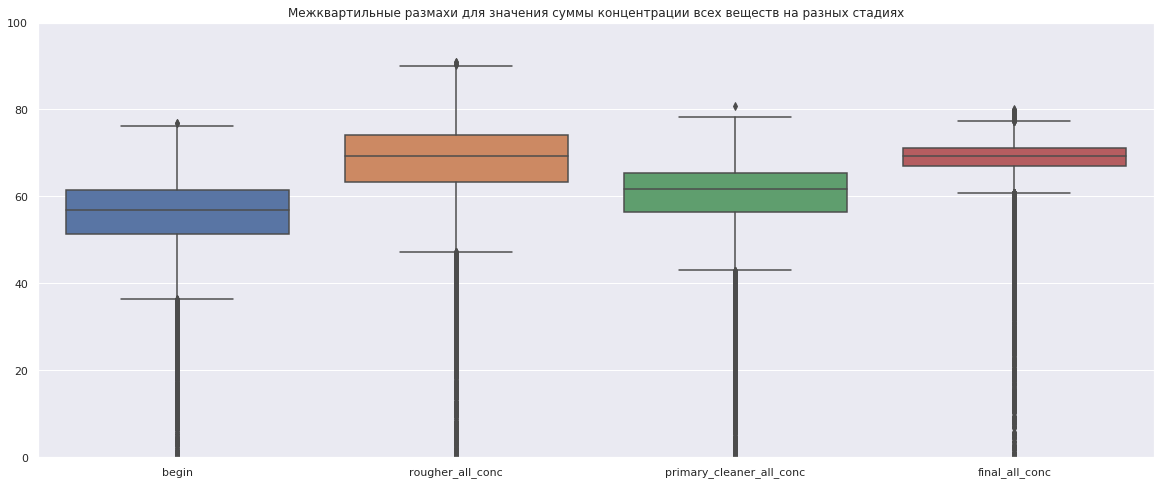

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sns.boxplot(data=data_full[['begin', 'rougher_all_conc', 'primary_cleaner_all_conc', 'final_all_conc']], ax=ax)
plt.title('Межквартильные размахи для значения суммы концентрации всех веществ на разных стадиях')
plt.ylim(0, 100)
plt.show()

Аномалии присутствуют на каждом из этапов. Стоит избавиться не от всех выбросов. Оставить небольшую долю, так мы оставим модели больше свободы в предсказании. Отсечем те объекты, сумма концентраций которых находится от 0-40%.

In [65]:
remove_begin = data_full.loc[data_full['begin'] < 40, 'date'].tolist()
remove_rougher = data_full.loc[data_full['rougher_all_conc'] < 40, 'date'].tolist()
remove_primary = data_full.loc[data_full['primary_cleaner_all_conc'] < 40, 'date'].tolist()
remove_final = data_full.loc[data_full['final_all_conc'] < 40, 'date'].tolist()

In [66]:
data_train.drop(data_train.query("date in @remove_begin or date in @remove_rougher or date in @remove_primary or date in @remove_final").index.tolist(), axis=0, inplace=True)
data_test.drop(data_test.query("date in @remove_begin or date in @remove_rougher or date in @remove_primary or date in @remove_final").index.tolist(), axis=0, inplace=True)

In [67]:
data_full.drop(data_full.query("date in @remove_begin or date in @remove_rougher or date in @remove_primary or date in @remove_final").index.tolist(), axis=0, inplace=True)

Посмотрим на то, как изменились ящики с усами после удаления части выбросов.

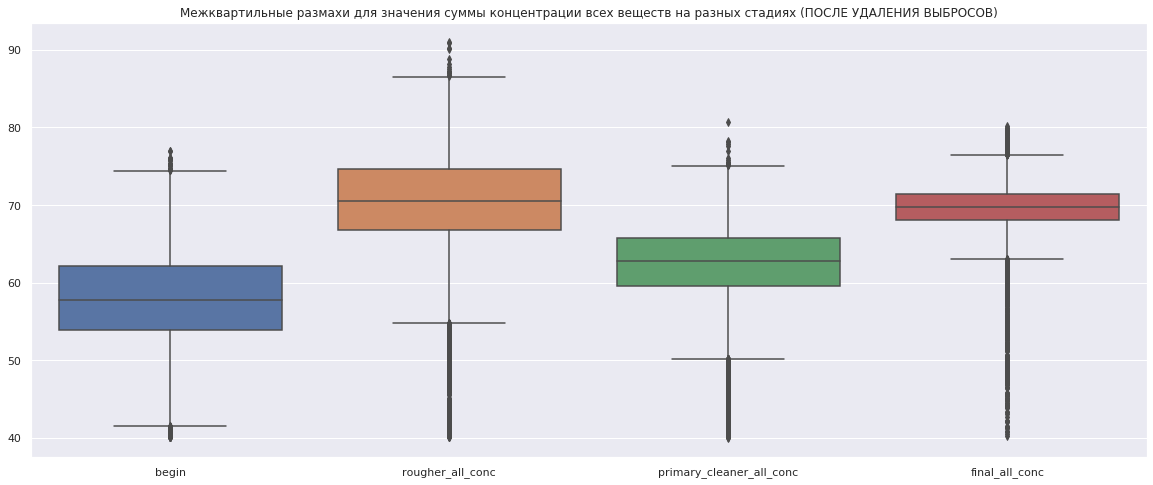

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sns.boxplot(data=data_full[['begin', 'rougher_all_conc', 'primary_cleaner_all_conc', 'final_all_conc']], ax=ax)
plt.title('Межквартильные размахи для значения суммы концентрации всех веществ на разных стадиях (ПОСЛЕ УДАЛЕНИЯ ВЫБРОСОВ)')
plt.show()

## Модель

### Функция для вычисления MAPE

In [69]:
def smape(y_pred, y_real):
    smape_rougher = np.sum(np.abs(y_real[:, 0] - y_pred[:, 0]) / (np.abs(y_real[:, 0]) + np.abs(y_pred[:, 0]) / 2)) * 100 / y_pred.shape[0]
    smape_final = np.sum(np.abs(y_real[:, 1] - y_pred[:, 1]) / (np.abs(y_real[:, 1]) + np.abs(y_pred[:, 1]) / 2)) * 100 / y_pred.shape[0]
    return 0.25 * smape_rougher + 0.75 * smape_final

In [70]:
smape_scorer = make_scorer(smape, greater_is_better=False)

### Построение моделей

Перед нами стоит задачи регрессии. Рассмотрим модели k-ближайших соседей, линейной регрессии, случайного леса.

#### Предобработка данных для машинного обучения

В данных отсутствуют категориальные признаки, поэтому этап кодирования категориальных признаков можем пропустить. Необходимо удалить те признаки, которые отсутствуют в тестовой выборке, но есть в обучающей. А также и в том, и в другом столбцах необходимо удалить столбец date, так как он не несет в себе полезной информации для обучения.

In [71]:
train_features = data_test.columns.tolist()

In [72]:
data_train = data_train[train_features]
data_train.head(2)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,70.541216
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,69.266198


In [73]:
data_train.drop(['date'], axis=1, inplace=True)
data_test.drop(['date'], axis=1, inplace=True)

Разбивать данные на несколько выборок не будем, так как в дальнейшем будем использовать кросс-валидацию, которая делает эту операция сама.

Выделим матрицу признаков и матрицу целевых переменных для каждой из выборок.

In [74]:
X_train = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
X_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_train = data_train[['rougher.output.recovery', 'final.output.recovery']].to_numpy()
y_test = data_test[['rougher.output.recovery', 'final.output.recovery']].to_numpy()

Промасштабируем данные, приведя к одному масштабу все признаки. Используем для этого стандартизацию.

In [75]:
st_scaler = StandardScaler()
st_scaler.fit(X_train)
X_train = st_scaler.transform(X_train)
X_test = st_scaler.transform(X_test)

#### Некоторы параметры для кросс-валидации

In [76]:
cv = KFold(n_splits=5, shuffle=True, random_state=7)

#### KNN

In [77]:
model_gs_knn = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={
        'weights': ['distance'],
        'n_neighbors': range(5, 50, 2),
        'p': range(1, 3)
    },
    cv=cv,
    n_jobs=-1,
    scoring=smape_scorer
)

In [78]:
model_gs_knn.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': range(5, 50, 2), 'p': range(1, 3),
                         'weights': ['distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(smape, greater_is_better=False), verbose=0)

In [79]:
model_gs_knn.cv_results_['mean_test_score']

array([-2.59839149, -2.65029372, -2.66937889, -2.71118314, -2.73068152,
       -2.7735161 , -2.78363002, -2.82679739, -2.83052422, -2.86849766,
       -2.86939927, -2.90992928, -2.90483623, -2.95009215, -2.9391676 ,
       -2.98771701, -2.9735098 , -3.01814113, -3.00557357, -3.05041796,
       -3.03349023, -3.08135107, -3.06167632, -3.11058829, -3.08655341,
       -3.13801326, -3.1096377 , -3.16267255, -3.13221314, -3.18435979,
       -3.1525308 , -3.2053473 , -3.17225539, -3.22595601, -3.19144347,
       -3.24498349, -3.21033201, -3.26279045, -3.22731642, -3.28071378,
       -3.24289363, -3.29552915, -3.25793494, -3.31070269, -3.27207534,
       -3.32470112])

In [80]:
print(f"Среднее качество модели по метрике smape: {abs(model_gs_knn.cv_results_['mean_test_score'].mean())}")
print(f"Лучшее качество модели по метрике smape: {abs(model_gs_knn.best_score_)}")

Среднее качество модели по метрике smape: 3.044124780992683
Лучшее качество модели по метрике smape: 2.5983914926765626


In [81]:
model_gs_knn.best_params_

{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

#### Линейная регрессия

В линейной регресси отсутствуют какие-либо параметры для подбора.

In [83]:
model_gs_lr = GridSearchCV(
    LinearRegression(),
    param_grid={},
    cv=cv,
    n_jobs=-1,
    scoring=smape_scorer
)

In [84]:
model_gs_lr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring=make_scorer(smape, greater_is_better=False), verbose=0)

In [85]:
print(f"Среднее качество модели по метрике smape: {abs(model_gs_lr.cv_results_['mean_test_score'].mean())}")
print(f"Лучшее качество модели по метрике smape: {abs(model_gs_lr.best_score_)}")

Среднее качество модели по метрике smape: 4.4202049459536905
Лучшее качество модели по метрике smape: 4.4202049459536905


In [86]:
model_gs_lr.best_params_

{}

#### Случайный лес

In [88]:
model_gs_rf = GridSearchCV(
    RandomForestRegressor(),
    param_grid={
        'n_estimators': range(10, 100, 10),
        'max_depth': range(3, 6)
    },
    cv=cv,
    n_jobs=-1,
    scoring=smape_scorer
)

In [89]:
model_gs_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,

In [90]:
print(f"Среднее качество модели по метрике smape: {abs(model_gs_rf.cv_results_['mean_test_score'].mean())}")
print(f"Лучшее качество модели по метрике smape: {abs(model_gs_rf.best_score_)}")

Среднее качество модели по метрике smape: 4.31209020697322
Лучшее качество модели по метрике smape: 4.085278826125198


In [91]:
model_gs_rf.best_params_

{'max_depth': 5, 'n_estimators': 70}

### Отбор и тестирование лучшей модели

Лучшие метрики качества на валидационной выборке показала модель kNN.

In [93]:
final_model = KNeighborsRegressor(n_neighbors=5, p=1, weights='distance')

In [94]:
final_model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                    weights='distance')

In [95]:
pred = final_model.predict(X_test)

In [96]:
smape(pred, y_test)

4.8760289358450555

### Проверка на адекватность

In [97]:
dc = DummyRegressor()
model_dc = dc.fit(X_train, y_train)
y_pred_test = model_dc.predict(X_test)
print(f'sMAPE Dummy Regressor (на тесте): {smape(y_pred_test, y_test)}')

sMAPE Dummy Regressor (на тесте): 4.809572250612017


Константная модель получается немного лучше, чем лучшая модель... Построенная модель неадекватна, внедрять в производство ее пока рано, необходимо дальнейшее исследование.

## Вывод

Построить модель по имеющимся данным не получилось.